In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
train_data_dir = "/content/drive/MyDrive/Brain Tumor Dataset/Brain Tumor/Training"
test_data_dir = "/content/drive/MyDrive/Brain Tumor Dataset/Brain Tumor/Testing"

In [ ]:
image_size = (224, 224)
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

Found 4571 images belonging to 4 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
validation_generator = validation_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 1141 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 1331 images belonging to 4 classes.


In [ ]:
densenet_model = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

for layer in densenet_model.layers:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  densenet_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1024)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,333,316 (27.97 MB)

 Trainable params: 295,812 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']+
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1412s 10s/step - accuracy: 0.5889 - loss: 6.1477 - val_accuracy: 0.7327 - val_loss: 0.7668
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.8710 - loss: 0.3625 - val_accuracy: 0.7765 - val_loss: 0.6519
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 601ms/step - accuracy: 0.8888 - loss: 0.3141 - val_accuracy: 0.7870 - val_loss: 0.5838
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.8950 - loss: 0.2953 - val_accuracy: 0.7169 - val_loss: 0.8869
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 582ms/step - accuracy: 0.8907 - loss: 0.3100 - val_accuracy: 0.7686 - val_loss: 0.7809
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 585ms/step - accuracy: 0.9002 - loss: 0.2743 - val_accuracy: 0.7862 - val_loss: 0.5963
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 587ms/step - accuracy: 0.8925 - loss: 0.2953 - val_accuracy: 0.8379 - val_loss: 0.5031
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 578ms/step - accuracy: 0.9018 - loss:

In [ ]:
model.save('my_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

42/42 ━━━━━━━━━━━━━━━━━━━━ 493s 12s/step - accuracy: 0.8397 - loss: 0.4910
Test Loss: 0.39916592836380005
Test Accuracy: 0.8812922835350037


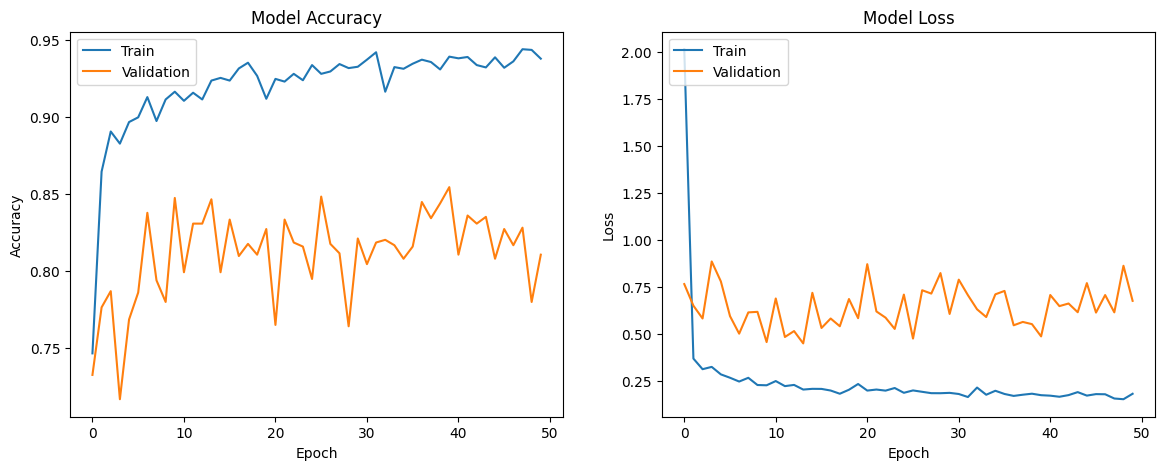

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_metrics(history)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step


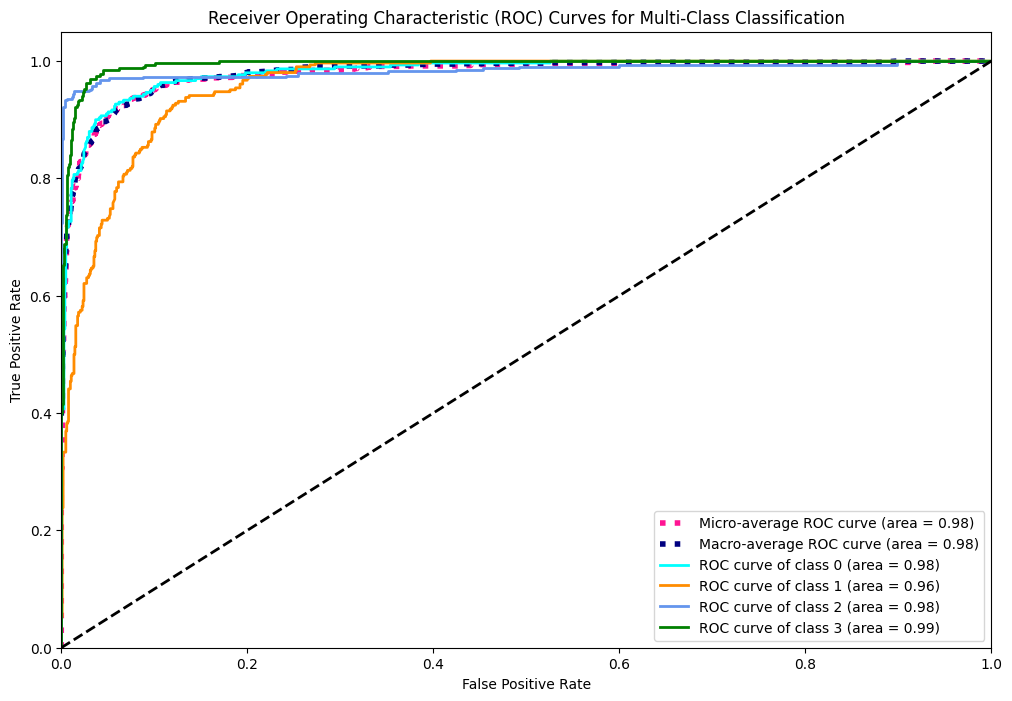

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step


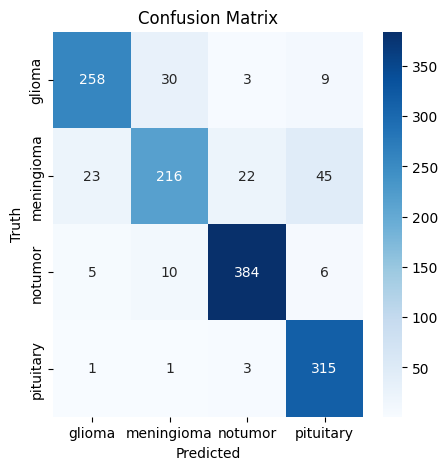

              precision    recall  f1-score   support

      glioma       0.90      0.86      0.88       300
  meningioma       0.84      0.71      0.77       306
     notumor       0.93      0.95      0.94       405
   pituitary       0.84      0.98      0.91       320

    accuracy                           0.88      1331
   macro avg       0.88      0.87      0.87      1331
weighted avg       0.88      0.88      0.88      1331



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


y_true = test_generator.classes  # Actual numerical labels

# Get predicted labels
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Class names (from test_generator)
class_names = list(test_generator.class_indices.keys())  # Extract class names

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Remove `labels=class_names`

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))